In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', None)

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
%reload_ext autoreload
from src.datasets.LFWDatasetSkewed import LFWDatasetSkewed

lfw_dataset = LFWDatasetSkewed()
train_dataset, valid_dataset, test_dataset = lfw_dataset.get_datasets()

print(train_dataset[0])

(tensor([[[0.3333, 0.3373, 0.3451,  ..., 0.3373, 0.3451, 0.3490],
         [0.3333, 0.3373, 0.3412,  ..., 0.3020, 0.3020, 0.3020],
         [0.3255, 0.3216, 0.3255,  ..., 0.3333, 0.3333, 0.3333],
         ...,
         [0.8078, 0.7608, 0.7059,  ..., 0.6902, 0.6784, 0.6745],
         [0.7412, 0.6980, 0.6784,  ..., 0.6824, 0.6745, 0.6667],
         [0.6980, 0.6745, 0.6706,  ..., 0.6784, 0.6667, 0.6588]],

        [[0.2667, 0.2706, 0.2784,  ..., 0.2980, 0.3059, 0.3098],
         [0.2667, 0.2706, 0.2745,  ..., 0.2627, 0.2627, 0.2627],
         [0.2588, 0.2549, 0.2588,  ..., 0.2902, 0.2902, 0.2902],
         ...,
         [0.7373, 0.6902, 0.6353,  ..., 0.5686, 0.5647, 0.5608],
         [0.6667, 0.6235, 0.6078,  ..., 0.5608, 0.5569, 0.5490],
         [0.6235, 0.6000, 0.5961,  ..., 0.5529, 0.5451, 0.5373]],

        [[0.2353, 0.2392, 0.2471,  ..., 0.2902, 0.2980, 0.3020],
         [0.2275, 0.2314, 0.2392,  ..., 0.2549, 0.2549, 0.2549],
         [0.2157, 0.2157, 0.2196,  ..., 0.2824, 0.2824, 0

/Users/I518152/Documents/GitHub/master-thesis/src/datasets/LFWDatasetSkewed.py:55: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  attributes_dataframe = attributes_dataframe.applymap(apply_rule)


torch.Size([3, 128, 128])


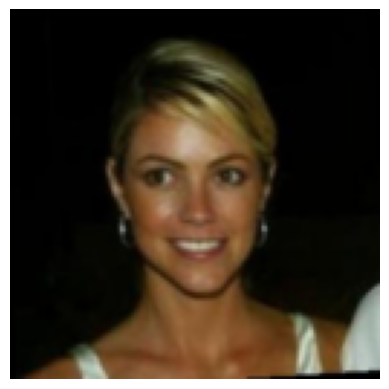

In [4]:
image_array = np.transpose(train_dataset[1][0], (1, 2, 0))
print(train_dataset[0][0].size())

plt.imshow(image_array)
plt.axis('off')
plt.show()

In [15]:
train_df = lfw_dataset.get_train_dataframe()
train_df =  train_df.drop(columns=[col for col in train_df.columns if 'Unnamed' in col])
print(train_df.head())

                      person  imagenum  Male  Asian  White  Black  Baby  \
7603         Kristanna Loken         2     0      0      1      0     0   
2037   Christine Baumgartner         5     0      0      1      0     0   
3282           Edwina Currie         1     0      0      1      0     0   
486            Amer al-Saadi         3     1      0      0      0     0   
10767        Robert Marshall         1     1      0      1      0     0   

       Child  Youth  Middle Aged  ...  High Cheekbones  Brown Eyes  \
7603       0      1            0  ...                1           0   
2037       0      1            0  ...                1           1   
3282       0      0            0  ...                1           0   
486        0      0            0  ...                0           1   
10767      0      1            0  ...                0           0   

       Wearing Earrings  Wearing Necktie  Wearing Necklace  \
7603                  1                0                 1   
2037

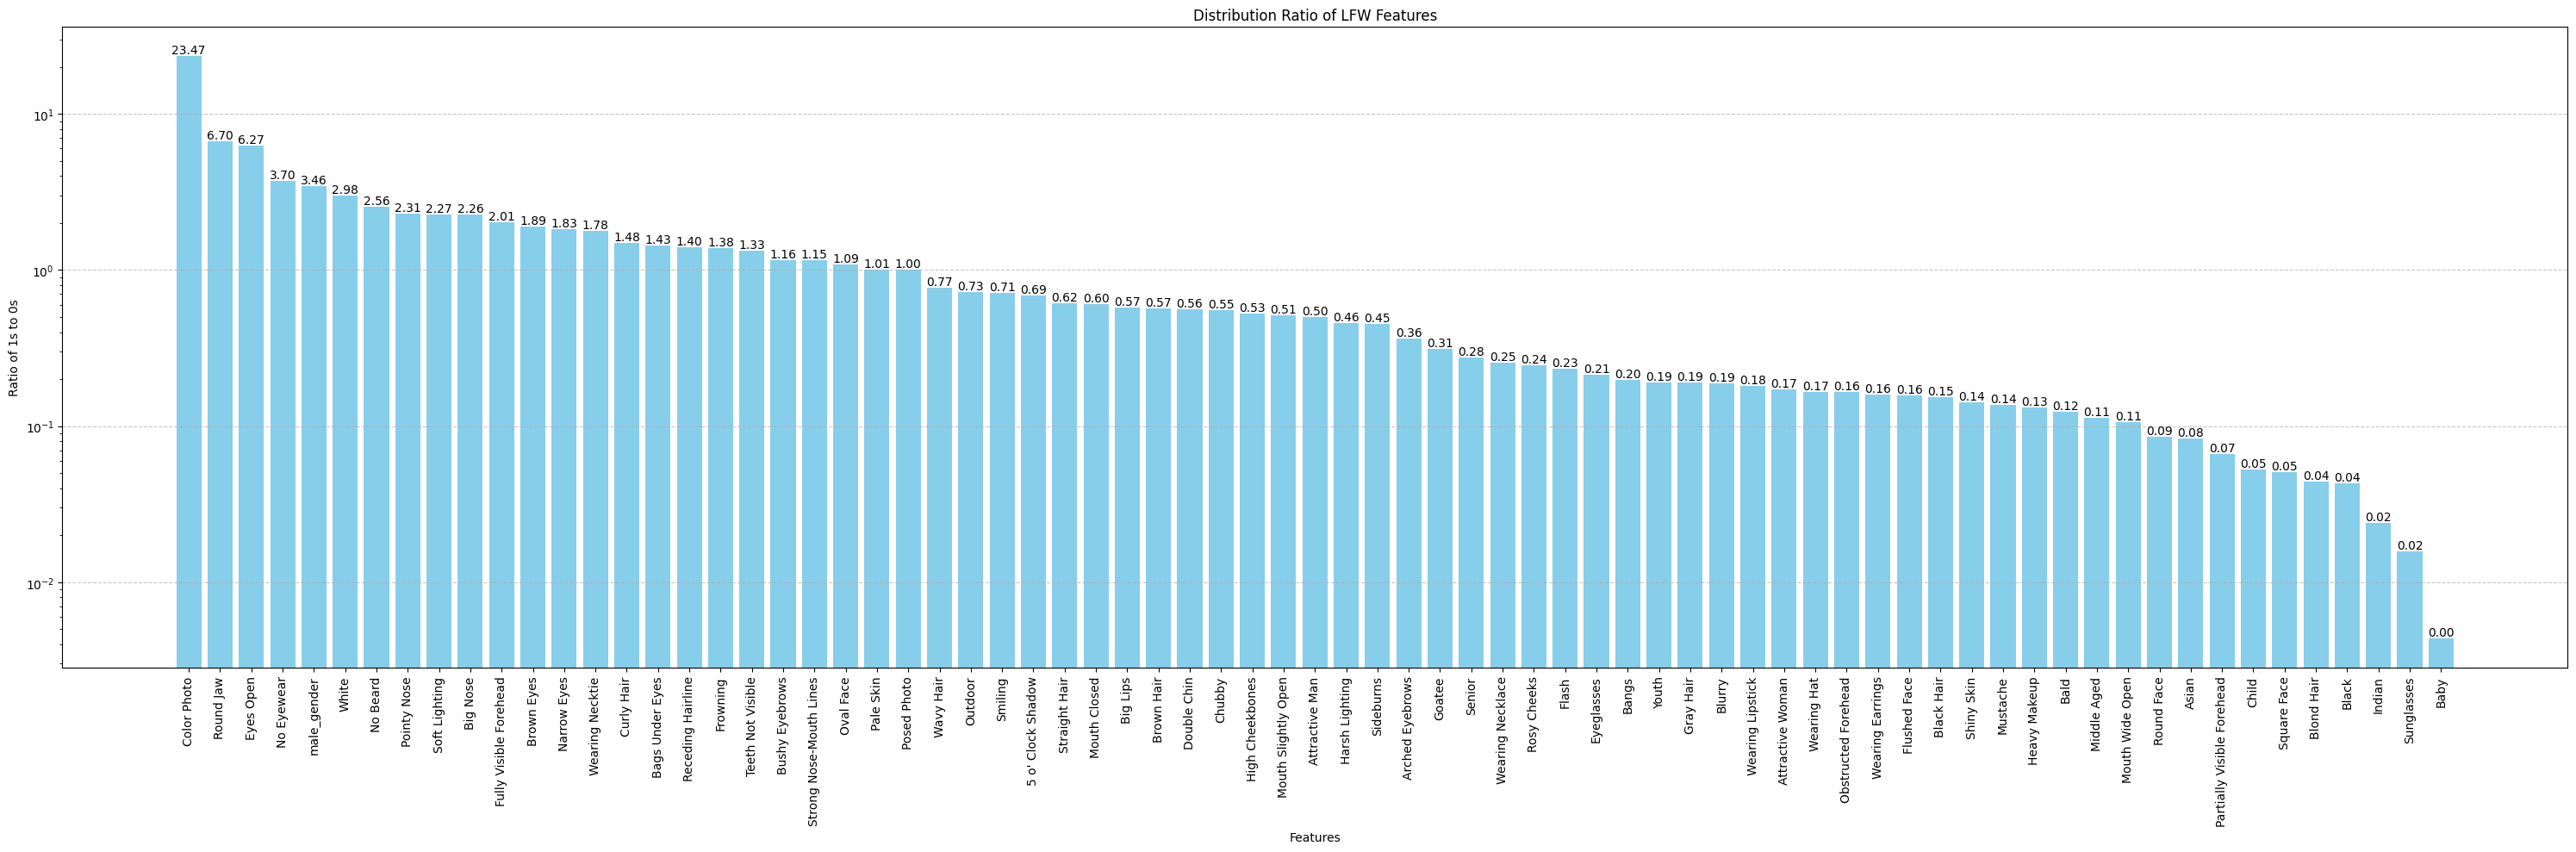

In [76]:
import copy

df = copy.deepcopy(train_df)
features = []
ratios = []

for column in df.columns:
     if column not in set(['Male', 'person', 'imagenum', "filename_person", "filename_complete", "protected_feature_encoded", "target_encoded"]):
        # Count the number of samples for each class (0 and 1) for the current feature
        counts = df[column].value_counts(normalize=True)
        
        # Ensure both 0 and 1 are present in the value_counts, else fill with 0
        zero_count = counts.get(0, 0)
        one_count = counts.get(1, 0)
        
        # Calculate the ratio
        ratio = one_count / zero_count if zero_count != 0 else np.inf
        
        # Append to lists
        features.append(column)
        ratios.append(ratio)

# Combine the features and ratios into a list of tuples and sort by ratio in descending order
sorted_pairs = sorted(zip(features, ratios), key=lambda x: x[1], reverse=True)
sorted_features, sorted_ratios = zip(*sorted_pairs)

# Create a bar plot
plt.figure(figsize=(30, 10))
bars = plt.bar(sorted_features, sorted_ratios, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Ratio of 1s to 0s')
plt.title('Distribution Ratio of LFW Features')
plt.xticks(rotation=90)
plt.yscale('log')  # Use a logarithmic scale for better visualization of large ratios
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add the exact values above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=10)

# Show plot
plt.tight_layout()
plt.savefig("dataset_plots/lfw_target_ratio.png", dpi=200)
plt.show()

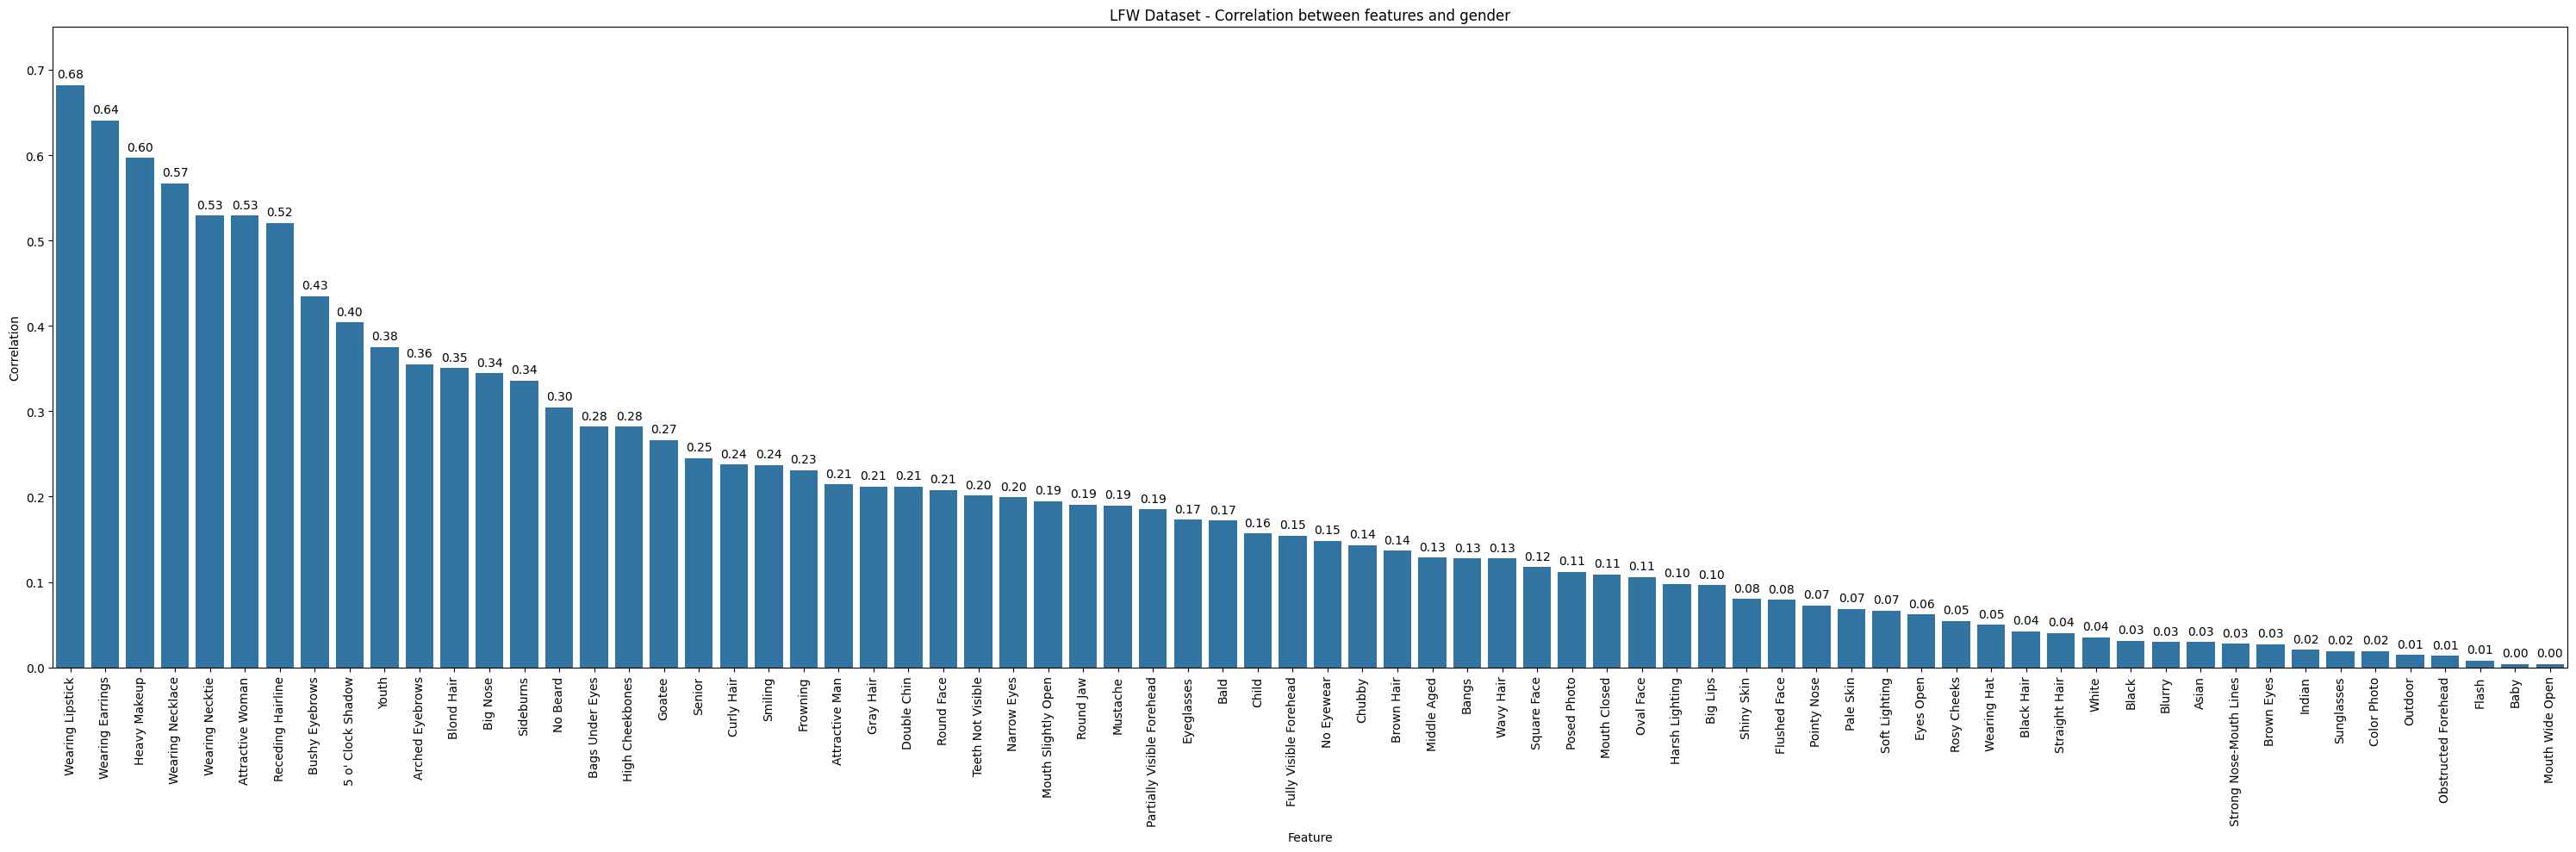

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr, pearsonr

correlations = {}
for column in train_df.columns:
    if column not in set(['Male', 'male_gender', 'person', 'imagenum', "filename_person", "filename_complete", "protected_feature_encoded", "target_encoded"]):
        corr, _ = pearsonr(train_df['male_gender'], train_df[column])
        correlations[column] = abs(corr)

correlation_df = pd.DataFrame(list(correlations.items()), columns=['Feature', 'Correlation'])
correlation_df = correlation_df.sort_values(by='Correlation', ascending=False)

plt.figure(figsize=(30, 10))
barplot = sns.barplot(x='Feature', y='Correlation', data=correlation_df)
plt.title('LFW Dataset - Correlation between features and gender')
plt.xlabel('Feature')
plt.xticks(rotation=90)
plt.ylabel('Correlation')
plt.ylim(0,0.75)
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9), textcoords = 'offset points')

plt.tight_layout()
plt.savefig("dataset_plots/lfw_correlation.png", dpi=200)
plt.show()

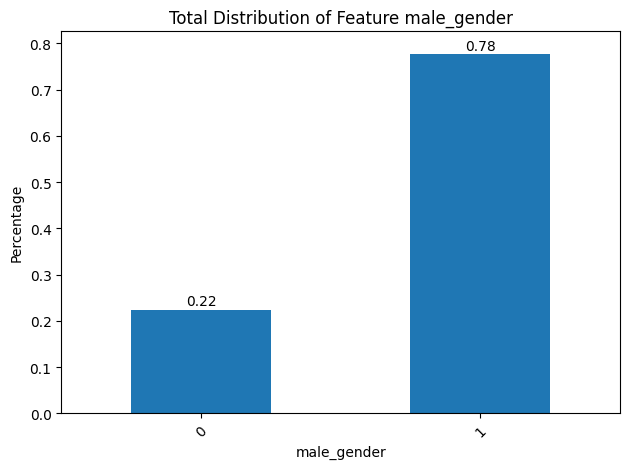

In [6]:
%reload_ext autoreload
from jupyter_notebooks.dataset_analysis.dataset_analysis_utils import plot_target_distribution

plot_target_distribution(train_df, "male_gender")

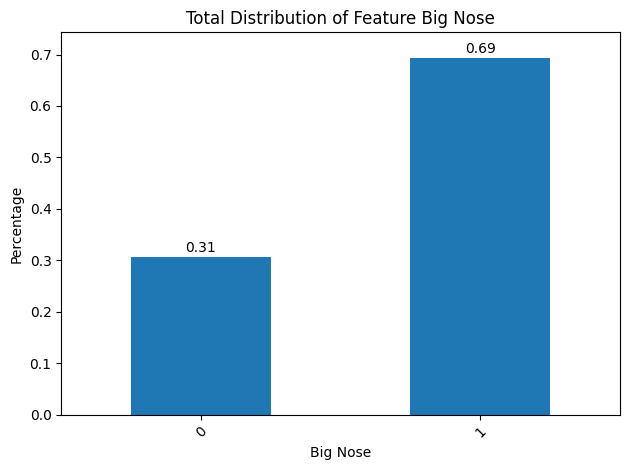

In [7]:
plot_target_distribution(train_df, "Big Nose")

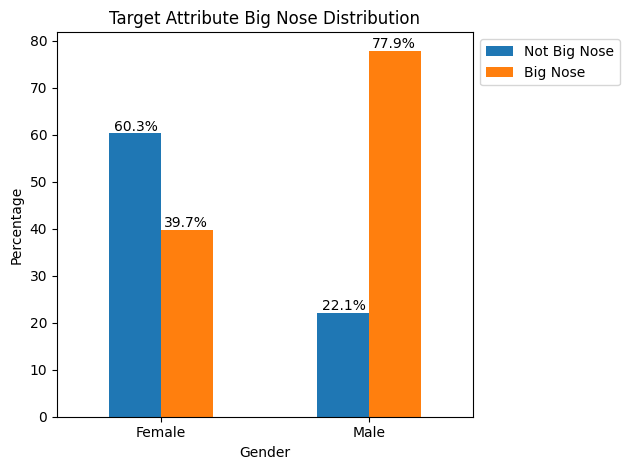

In [63]:
%reload_ext autoreload
from jupyter_notebooks.dataset_analysis.dataset_analysis_utils import plot_protected_feature_distribution, plot_protected_feature_distribution_binary

plot_protected_feature_distribution_binary(train_df, "Big Nose", "male_gender", title="Target Attribute Big Nose Distribution", save_fig_path="lfw_big_nose_distribution")

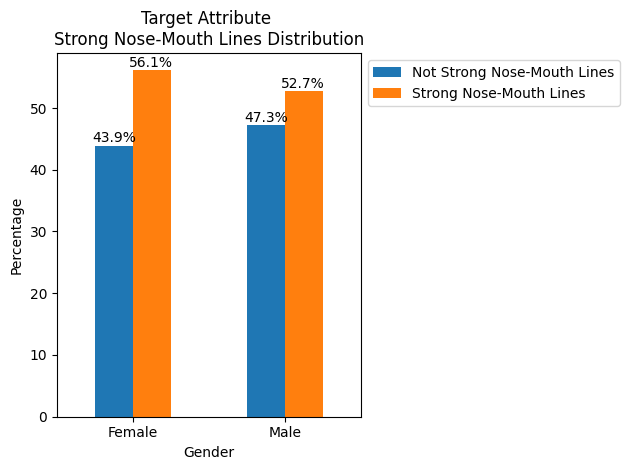

In [75]:
plot_protected_feature_distribution_binary(train_df, "Strong Nose-Mouth Lines", "male_gender", title="Target Attribute \nStrong Nose-Mouth Lines Distribution", save_fig_path="lfw_strong_nose_mouth_distribution")

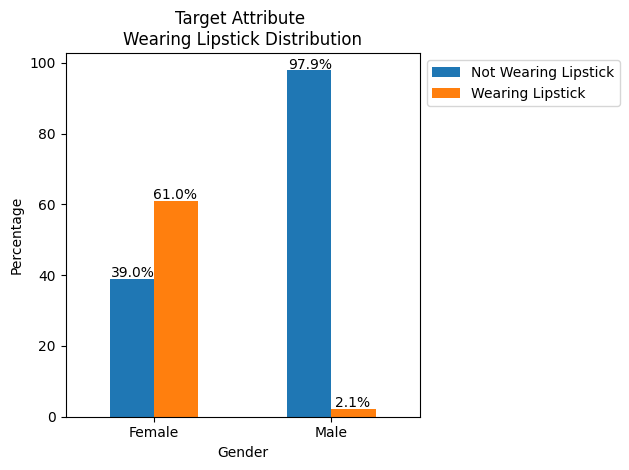

In [77]:
plot_protected_feature_distribution_binary(train_df, "Wearing Lipstick", "male_gender", title="Target Attribute \nWearing Lipstick Distribution", save_fig_path="lfw_wearing_lipstick_distribution")

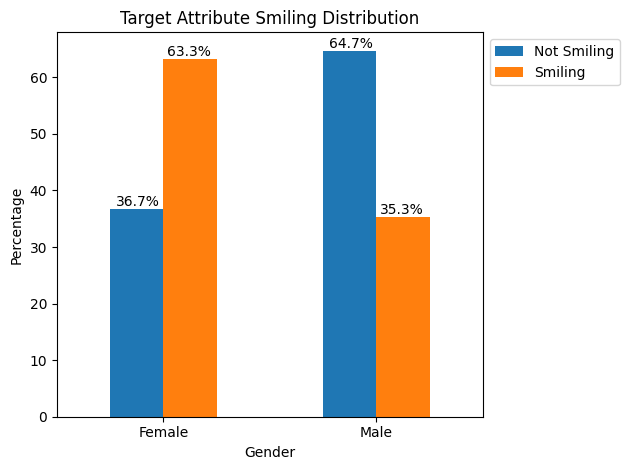

In [68]:
plot_protected_feature_distribution_binary(train_df, "Smiling", "male_gender", title="Target Attribute Smiling Distribution", save_fig_path="lfw_smiling_distribution")

In [9]:
lfw_dataset.calculate_pearson_correlation(train_df, "Big Nose", "male_gender")

0.34468888779742185